# Usage (quick version)

## Preparation

In [1]:
# Standard users
# !pip install covsirphy
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [2]:
import warnings

In [3]:
import covsirphy as cs
cs.__version__

'2.8.3'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/


Detailed citaition list:

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120711
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

### The number of cases (JHU style)

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [6]:
print(data_loader.covid19dh_citation)

Open Government Data, United Kingdom (2020), https://coronavirus.data.gov.uk
Department of Disease Control of Thailand (2020), https://covid19.th-stat.com/
World Health Organization (2020), https://covid19.who.int
Ireland Health Protection Surveillance Centre (HPSC) and Health Service Executive (HSE) (2020), https://covid19ireland-geohive.hub.arcgis.com/
The COVID Tracking Project (2020), https://covidtracking.com
Ministry of Health of Croatia (2020), https://data.gov.hr/dataset/koronavirus/resource/08fab529-ebba-46c7-be79-05782ddb02ef
Open Government Data, Latvia (2020), https://data.gov.lv/dati/dataset
Taiwan Ministry of Health and Welfare (2020), https://data.gov.tw/dataset/120711
Wikipedia (2020), https://en.wikipedia.org/wiki
Epistat, Belgian Infectious Diseases (2020), https://epistat.sciensano.be
Johns Hopkins Center for Systems Science and Engineering (2020), https://github.com/CSSEGISandData/COVID-19
Covid19data.com.au (2020), https://github.com/M3IT/COVID-19_Data
Data Science

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
266544,2020-09-24,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266545,2020-09-25,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266546,2020-09-26,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266547,2020-09-27,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266548,2020-09-28,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
266544,2020-09-24,Colombia,Vichada,14,0,0,14
266545,2020-09-25,Colombia,Vichada,14,0,0,14
266546,2020-09-26,Colombia,Vichada,14,0,0,14
266547,2020-09-27,Colombia,Vichada,14,0,0,14
266548,2020-09-28,Colombia,Vichada,14,0,0,14


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
189,2020-09-24,24648,2402,395,21851
190,2020-09-25,24843,2323,399,22121
191,2020-09-26,25113,2284,400,22429
192,2020-09-27,25257,2307,400,22550
193,2020-09-28,25335,2282,406,22647


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-09-24,31937051,8985150,978228,21973673,0.015315,0.344015,0.042621
2020-09-25,32255682,9079603,983730,22192349,0.015249,0.344007,0.042446
2020-09-26,32543858,9147063,988959,22407836,0.015194,0.344271,0.042269
2020-09-27,32778102,9181472,992268,22604362,0.015136,0.344809,0.042051
2020-09-28,32778458,9180969,992280,22605209,0.015136,0.344818,0.042050


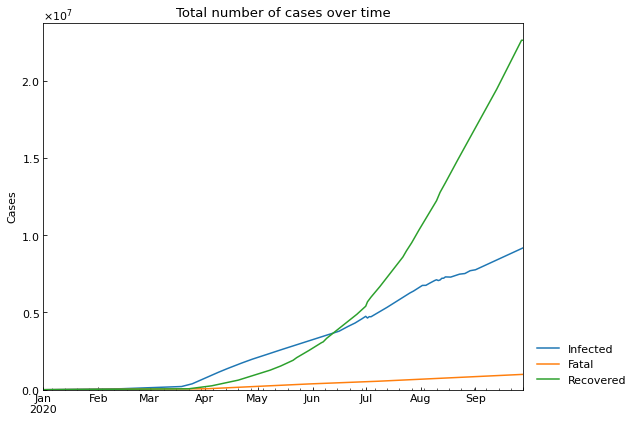

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan


In [12]:
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
228,2020-09-24,80502,6444,1536,72522
229,2020-09-25,81077,6070,1543,73464
230,2020-09-26,81720,6042,1546,74132
231,2020-09-27,82205,6068,1549,74588
232,2020-09-28,82491,5961,1560,74970


In [13]:
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan

In [14]:
jhu_data.replace(japan_data)
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
226,2020-09-24,80041,5983,1520,72538
227,2020-09-25,80497,5475,1532,73490
228,2020-09-26,81055,5364,1540,74151
229,2020-09-27,81690,5538,1545,74607
230,2020-09-28,82131,5593,1548,74990


### Population in each country

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
266544,2020-09-24,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266545,2020-09-25,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266546,2020-09-26,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266547,2020-09-27,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266548,2020-09-28,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
227655,COL,Colombia,Vichada,2020-09-24,107808
227656,COL,Colombia,Vichada,2020-09-25,107808
227657,COL,Colombia,Vichada,2020-09-26,107808
227658,COL,Colombia,Vichada,2020-09-27,107808
227659,COL,Colombia,Vichada,2020-09-28,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
We can get Citation list of primary sources with DataLoader(...).covid19dh_citation

In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
266544,2020-09-24,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266545,2020-09-25,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266546,2020-09-26,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266547,2020-09-27,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04
266548,2020-09-28,14,14,0,107808.0,COL,Vichada,Colombia,3,1,2,3,1,0,0,4,2,2,2,62.04


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
266544,2020-09-24,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
266545,2020-09-25,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
266546,2020-09-26,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
266547,2020-09-27,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04
266548,2020-09-28,Colombia,COL,3,1,2,3,1,0,0,4,2,2,2,62.04


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
267,2020-09-24,1,1,1,0,0,1,1,3,2,2,1,37.04
268,2020-09-25,1,1,1,0,0,1,1,3,2,2,1,37.04
269,2020-09-26,1,1,1,0,0,1,1,3,2,2,1,37.04
270,2020-09-27,1,1,1,0,0,1,1,3,2,2,1,37.04
271,2020-09-28,1,1,1,0,0,1,1,3,2,2,1,37.04


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
267,2020-09-24,1,1,1,0,0,1,1,3,2,2,1,37.04
268,2020-09-25,1,1,1,0,0,1,1,3,2,2,1,37.04
269,2020-09-26,1,1,1,0,0,1,1,3,2,2,1,37.04
270,2020-09-27,1,1,1,0,0,1,1,3,2,2,1,37.04
271,2020-09-28,1,1,1,0,0,1,1,3,2,2,1,37.04


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
scenario = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records

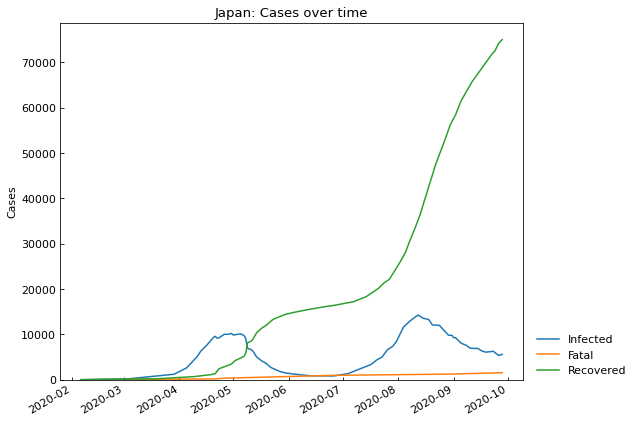

,Date,Confirmed,Infected,Fatal,Recovered
226,2020-09-24,80041,5983,1520,72538
227,2020-09-25,80497,5475,1532,73490
228,2020-09-26,81055,5364,1540,74151
229,2020-09-27,81690,5538,1545,74607
230,2020-09-28,82131,5593,1548,74990


In [26]:
import matplotlib
warnings.simplefilter("ignore", category=matplotlib.MatplotlibDeprecationWarning)
record_df = scenario.records()
record_df.tail()

### S-R trend analysis

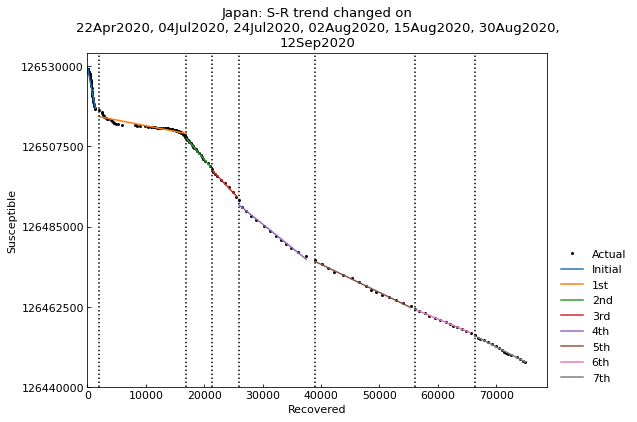

,Type,Start,End,Population
0th,Past,06Feb2020,21Apr2020,126529100
1st,Past,22Apr2020,03Jul2020,126529100
2nd,Past,04Jul2020,23Jul2020,126529100
3rd,Past,24Jul2020,01Aug2020,126529100
4th,Past,02Aug2020,14Aug2020,126529100
5th,Past,15Aug2020,29Aug2020,126529100
6th,Past,30Aug2020,11Sep2020,126529100
7th,Past,12Sep2020,28Sep2020,126529100


In [27]:
scenario.trend(set_phases=True)
scenario.summary()

### Hyperparameter estimation of ODE models
As an example, use SIR-F model.
We can use SIR, SIRD, (SIRFV), (SEWIRF).

In [28]:
scenario.estimate(cs.SIRF)


<SIR-F model: parameter estimation>

Running optimization with 4 CPUs...

	7th phase (12Sep2020 - 28Sep2020): finished  367 trials in 0 min 15 sec

	3rd phase (24Jul2020 - 01Aug2020): finished  684 trials in 0 min 25 sec

	0th phase (06Feb2020 - 21Apr2020): finished 1355 trials in 1 min  0 sec

	1st phase (22Apr2020 - 03Jul2020): finished 1317 trials in 1 min  0 sec

	2nd phase (04Jul2020 - 23Jul2020): finished 1389 trials in 1 min  0 sec

	5th phase (15Aug2020 - 29Aug2020): finished  312 trials in 0 min 10 sec

	6th phase (30Aug2020 - 11Sep2020): finished  303 trials in 0 min 10 sec

	4th phase (02Aug2020 - 14Aug2020): finished 1423 trials in 1 min  0 sec

Completed optimization. Total: 1 min 41 sec

In [29]:
scenario.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,1/gamma [day],alpha1 [-],1/beta [day],1/alpha2 [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,21Apr2020,126529100,SIR-F,4.22,0.000302,0.001063,0.052213,0.011310,720,44,0.000,9,470,0.952248,1355,1 min 0 sec
1st,Past,22Apr2020,03Jul2020,126529100,SIR-F,0.34,0.110495,0.000251,0.012522,0.032141,720,15,0.110,39,1993,0.809514,1317,1 min 0 sec
2nd,Past,04Jul2020,23Jul2020,126529100,SIR-F,2.09,0.001257,0.000046,0.069628,0.033279,720,15,0.001,7,10928,0.042221,1389,1 min 0 sec
3rd,Past,24Jul2020,01Aug2020,126529100,SIR-F,1.85,0.000589,0.000114,0.067612,0.036417,720,13,0.001,7,4397,0.020080,684,0 min 25 sec
4th,Past,02Aug2020,14Aug2020,126529100,SIR-F,1.46,0.000248,0.000188,0.048609,0.033005,720,15,0.000,10,2659,0.075828,1423,1 min 0 sec
5th,Past,15Aug2020,29Aug2020,126529100,SIR-F,0.76,0.000468,0.000552,0.039566,0.051693,720,9,0.000,12,906,0.050953,312,0 min 10 sec
6th,Past,30Aug2020,11Sep2020,126529100,SIR-F,0.70,0.000350,0.000711,0.034064,0.047663,720,10,0.000,14,702,0.013354,303,0 min 10 sec
7th,Past,12Sep2020,28Sep2020,126529100,SIR-F,0.88,0.004275,0.000530,0.043523,0.048950,720,10,0.004,11,942,0.031850,367,0 min 15 sec


### Accuracy of estimation

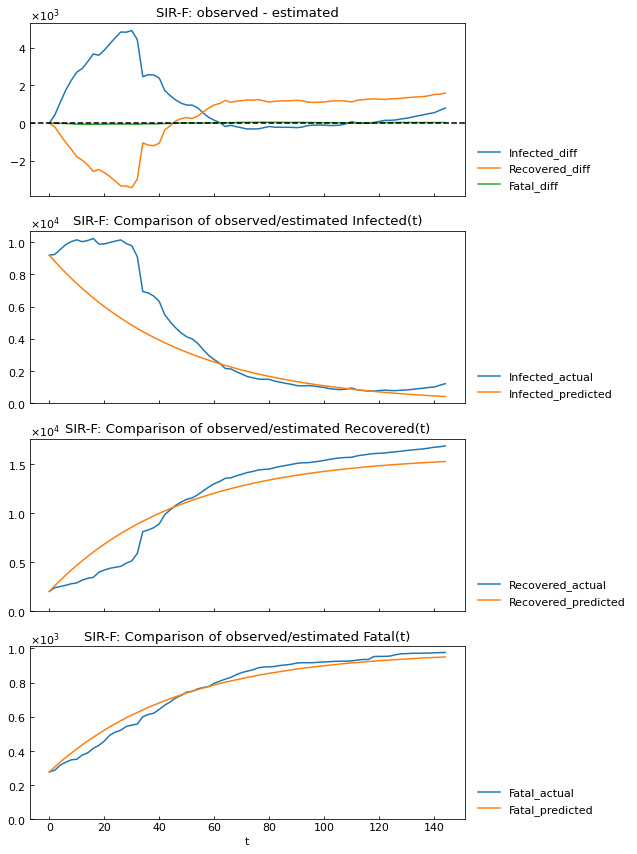

In [30]:
scenario.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
scenario.get("Rt", phase="4th")

1.46

### Show parameter history

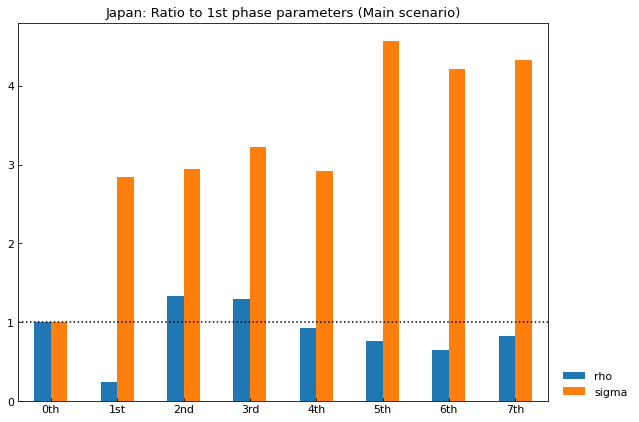

,0th,1st,2nd,3rd,4th,5th,6th,7th
rho,1.0,0.239835,1.333547,1.294936,0.930980,0.757777,0.65240,0.833575
sigma,1.0,2.841857,2.942502,3.219952,2.918258,4.570616,4.21424,4.328038


In [32]:
df = scenario.param_history(targets=["rho", "sigma"])
df.T

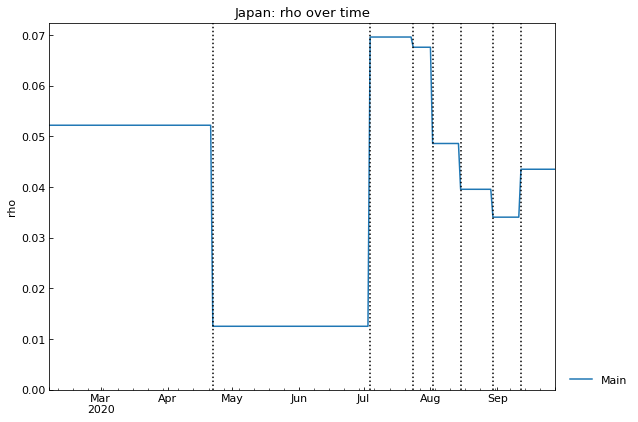

In [33]:
# version >= 2.8.0
_ = scenario.history(target="rho")

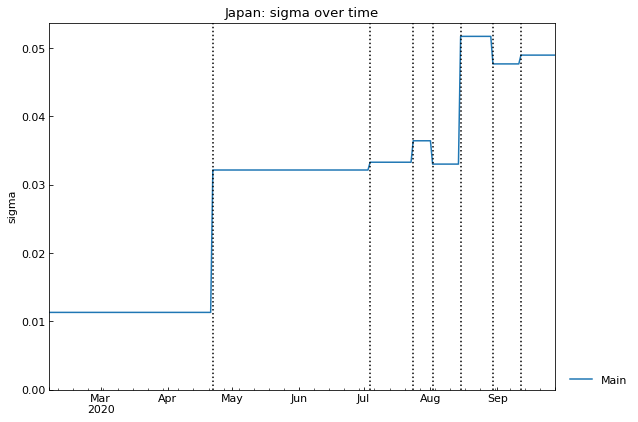

In [34]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

### Show the history of reproduction number

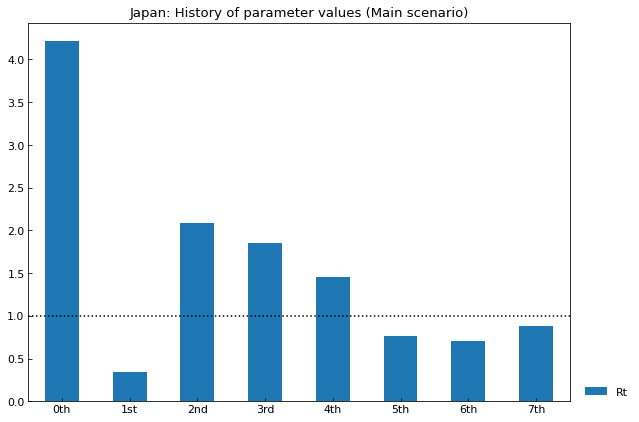

,0th,1st,2nd,3rd,4th,5th,6th,7th
Rt,4.22,0.34,2.09,1.85,1.46,0.76,0.7,0.88


In [35]:
df = scenario.param_history(targets=["Rt"], divide_by_first=False, show_box_plot=True)
df.T

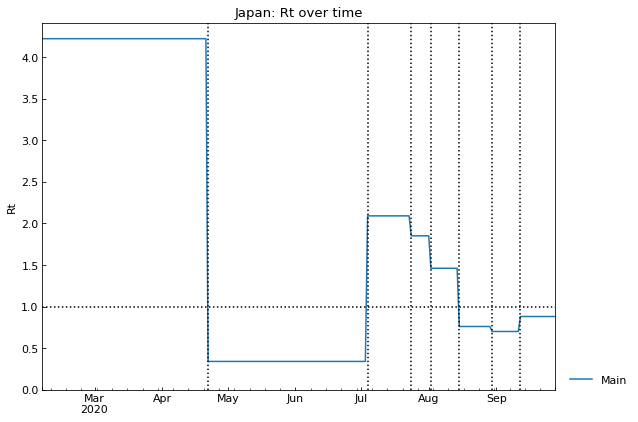

In [36]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

### Simulate the number of cases

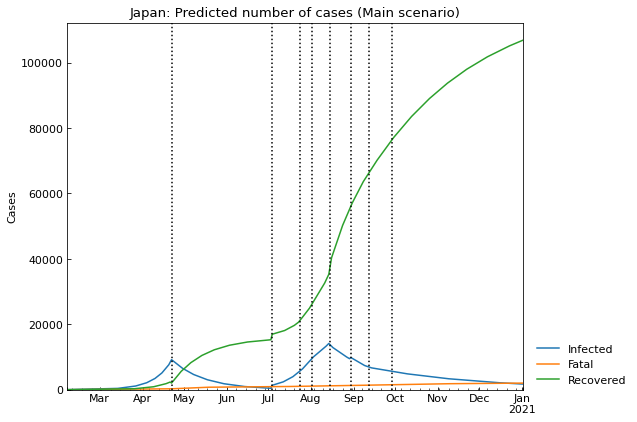

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,110022,2007,1803,106212
328,2020-12-30,110178,2010,1781,106387
329,2020-12-31,110332,2012,1760,106560
330,2021-01-01,110484,2015,1738,106731
331,2021-01-02,110634,2017,1717,106900


In [37]:
scenario.clear(name="Main")
scenario.add(end_date="01Jan2021", name="Main")
main_sim_df = scenario.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [38]:
sigma_current = scenario.get("sigma", name="Main", phase="last")
sigma_current

0.04894959970342885

In [39]:
sigma_new = sigma_current * 2
sigma_new

0.0978991994068577

In [40]:
scenario.clear(name="Medicine")
scenario.add(name="Medicine", days=30, sigma=sigma_current)
scenario.add(name="Medicine", end_date="01Jan2021", sigma=sigma_new)
scenario.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.22   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.34   
         2nd      Past  04Jul2020  23Jul2020   126529100  SIR-F  2.09   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.85   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.46   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.76   
         6th      Past  30Aug2020  11Sep2020   126529100  SIR-F  0.70   
         7th      Past  12Sep2020  28Sep2020   126529100  SIR-F  0.88   
         8th    Future  29Sep2020  01Jan2021   126529100  SIR-F  0.88   
Medicine 0th      Past  06Feb2020  21Apr2020   126529100  SIR-F  4.22   
         1st      Past  22Apr2020  03Jul2020   126529100  SIR-F  0.34   
         2nd      Past  04Jul2020  23Jul2020   126529100  SIR-F  2.09   
         3rd      Past  24Jul2020  01Aug2020   126529100  SIR-F  1.85   
         4th      Past  02Aug2020  14Aug2020   126529100  SIR-F  1.46   
         5th      Past  15Aug2020  29Aug2020   126529100  SIR-F  0.76   
         6th      Past  30Aug2020  11Sep2020   126529100  SIR-F  0.70   
         7th      Past  12Sep2020  28Sep2020   126529100  SIR-F  0.88   
         8th    Future  29Sep2020  28Oct2020   126529100  SIR-F  0.88   
         9th    Future  29Oct2020  01Jan2021   126529100  SIR-F  0.44   

                   theta     kappa       rho     sigma  tau  1/gamma [day]  \
Scenario Phase                                                               
Main     0th    0.000302  0.001063  0.052213  0.011310  720             44   
         1st    0.110495  0.000251  0.012522  0.032141  720             15   
         2nd    0.001257  0.000046  0.069628  0.033279  720             15   
         3rd    0.000589  0.000114  0.067612  0.036417  720             13   
         4th    0.000248  0.000188  0.048609  0.033005  720             15   
         5th    0.000468  0.000552  0.039566  0.051693  720              9   
         6th    0.000350  0.000711  0.034064  0.047663  720             10   
         7th    0.004275  0.000530  0.043523  0.048950  720             10   
         8th    0.004275  0.000530  0.043523  0.048950  720             10   
Medicine 0th    0.000302  0.001063  0.052213  0.011310  720             44   
         1st    0.110495  0.000251  0.012522  0.032141  720             15   
         2nd    0.001257  0.000046  0.069628  0.033279  720             15   
         3rd    0.000589  0.000114  0.067612  0.036417  720             13   
         4th    0.000248  0.000188  0.048609  0.033005  720             15   
         5th    0.000468  0.000552  0.039566  0.051693  720              9   
         6th    0.000350  0.000711  0.034064  0.047663  720             10   
         7th    0.004275  0.000530  0.043523  0.048950  720             10   
         8th    0.004275  0.000530  0.043523  0.048950  720             10   
         9th    0.004275  0.000530  0.043523  0.097899  720              5   

                alpha1 [-]  1/beta [day]  1/alpha2 [day]      RMSLE Trials  \
Scenario Phase                                                               
Main     0th         0.000             9             470   0.952248   1355   
         1st         0.110            39            1993   0.809514   1317   
         2nd         0.001             7           10928   0.042221   1389   
         3rd         0.001             7            4397  0.0200801    684   
         4th         0.000            10            2659   0.075828   1423   
         5th         0.000            12             906  0.0509527    312   
         6th         0.000            14             702  0.0133538    303   
         7th         0.004            11             942  0.0318505    367   
         8th         0.004            11             942         

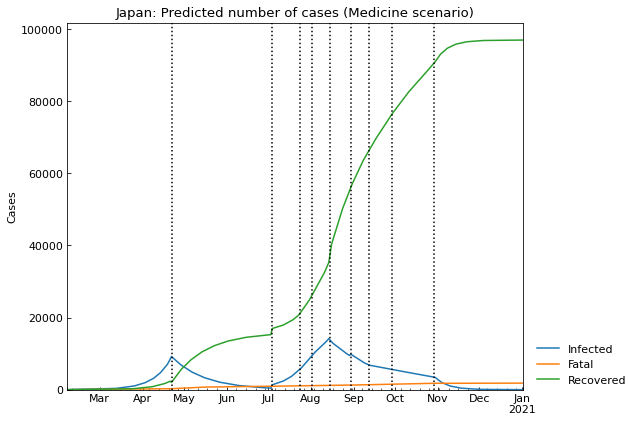

,Date,Confirmed,Fatal,Infected,Recovered
327,2020-12-29,98782,1822,5,96955
328,2020-12-30,98782,1822,4,96956
329,2020-12-31,98782,1822,4,96956
330,2021-01-01,98782,1822,3,96957
331,2021-01-02,98783,1822,3,96958


In [41]:
scenario.simulate(name="Medicine").tail()

### Compare the scenarios

In [42]:
scenario.describe()

,max(Infected),argmax(Infected),Infected on 02Jan2021,Fatal on 02Jan2021,9th_Rt
Main,14137,14Aug2020,1717,2017,-
Medicine,14137,14Aug2020,3,1822,0.44


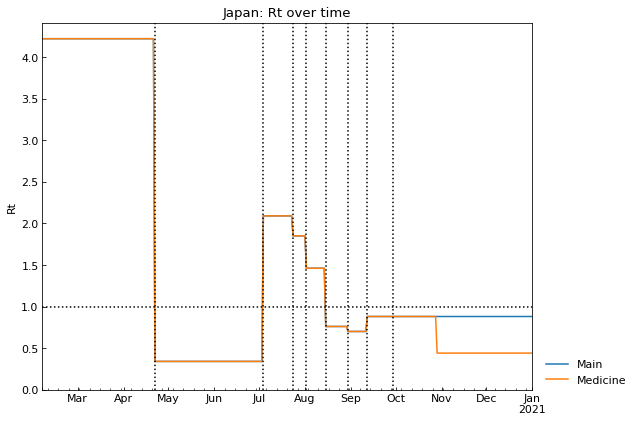

In [43]:
# version >= 2.8.0
_ = scenario.history(target="Rt")

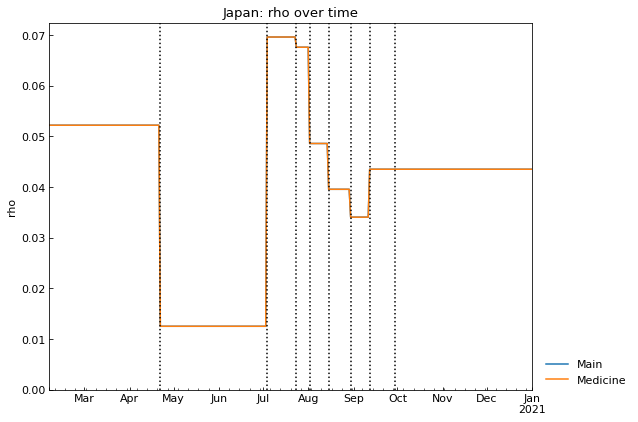

In [44]:
# version >= 2.8.0
_ = scenario.history(target="rho")

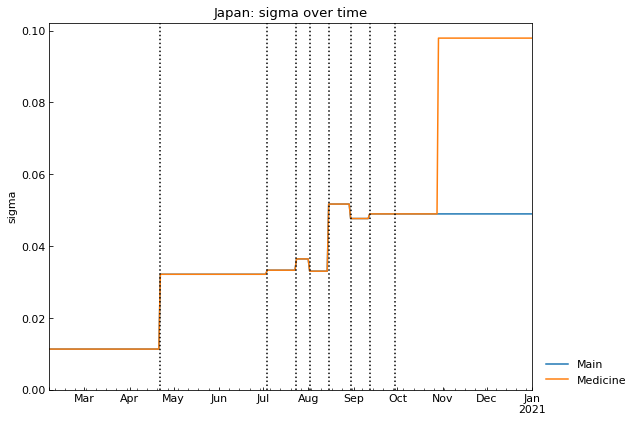

In [45]:
# version >= 2.8.0
_ = scenario.history(target="sigma")

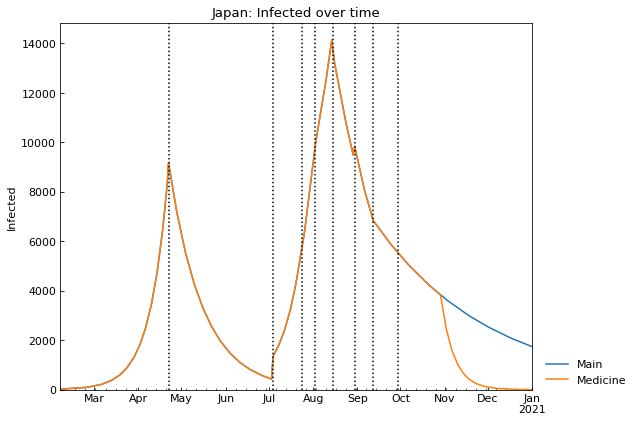

In [46]:
# version >= 2.8.0
_ = scenario.history(target="Infected")